In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("drive/MyDrive/hse_diploma/data_after_selection.csv")
del df["Unnamed: 0"]
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time').sort_index()
df = df.asfreq('MS')

X = df.copy()
X['inflation_rate'] = X.inflation_rate.shift(-6)
X.dropna(inplace=True)

# Пример

In [4]:
x_train = X.iloc[:-6]
x_test = X.iloc[-6:]

exog_train = x_train.drop(columns=["inflation_rate"])
target_train = x_train.inflation_rate

exog_test = x_test.drop(columns=["inflation_rate"])
target_test = x_test.inflation_rate

# Определение параметров SARIMAX
# Пример: (p,d,q) = (1,1,1), сезонные (P,D,Q,s) = (1,1,1,12) для месячных данных
# Вам нужно подобрать эти параметры, здесь просто шаблон
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Построение модели
model = sm.tsa.SARIMAX(endog=target_train, exog=exog_train, order=order, seasonal_order=seasonal_order,
                       enforce_stationarity=False, enforce_invertibility=False)

# Обучение модели
results = model.fit(disp=False)

# Результаты
print(results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                     inflation_rate   No. Observations:                  280
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -150.652
Date:                            Fri, 23 May 2025   AIC                            911.304
Time:                                    10:43:25   BIC                           1988.988
Sample:                                01-01-2001   HQIC                          1344.892
                                     - 04-01-2024                                         
Covariance Type:                              opg                                         
                                                                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [5]:
# Прогноз на будущие периоды (6 месяцев вперед)
# Для прогноза нужна экзогенная матрица на будущие периоды (exog_forecast)
# exog_forecast должен быть DataFrame с 6 строками и теми же столбцами, что exog
y = X["inflation_rate"].copy()
forecast = results.predict(start=len(X), end=len(X)+5, exog=X.drop(columns=["inflation_rate"]).iloc[-12:])
print(forecast)

2024-11-01    3.313265
2024-12-01    5.346664
2025-01-01    6.610178
2025-02-01    5.076764
2025-03-01    4.175210
2025-04-01    4.509471
Freq: MS, Name: predicted_mean, dtype: float64


# Подбор гиперпараметров

In [9]:
# Целевая и экзогенные переменные:
y = X['inflation_rate']
exog = X.drop(columns=['inflation_rate'])

# Разбиваем на train и validation по времени
validation_period = 6  # месяцев

y_train = y.iloc[:-validation_period]
exog_train = exog.iloc[:-validation_period]

y_val = y.iloc[-validation_period:]
exog_val = exog.iloc[-validation_period:]

In [8]:
from itertools import product

# Сетки для перебора параметров (для упрощения — небольшие диапазоны)
p = d = q = [1,2]  # значения 0,1,2 для p,d,q
P = D = Q = [0,1]  # 0 или 1 для сезонных параметров
s = [6,12]  # сезонность, например, для месячных данных

param_grid = list(product(p, d, q))
seasonal_param_grid = list(product(P, D, Q, s))

best_aic = float('inf')
best_order = None
best_seasonal_order = None
best_model = None

for order in param_grid:
    for seasonal_order in seasonal_param_grid:
        try:
            model = sm.tsa.SARIMAX(endog=y_train, exog=exog_train,
                                   order=order,
                                   seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], seasonal_order[3]),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = (seasonal_order[0], seasonal_order[1], seasonal_order[2], seasonal_order[3])
                best_model = results
            print(f"Tested SARIMAX{order}x{seasonal_order} - AIC:{results.aic:.2f}")
        except Exception as e:
            # Иногда модель не сходится — пропускаем такие комбинации
            print(f"Failed SARIMAX{order}x{seasonal_order}: {e}")
            continue

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(0, 0, 0, 6) - AIC:765.13


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(0, 0, 0, 12) - AIC:765.13


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(0, 0, 1, 6) - AIC:765.47
Tested SARIMAX(1, 1, 1)x(0, 0, 1, 12) - AIC:732.56


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(0, 1, 0, 6) - AIC:933.19


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(0, 1, 0, 12) - AIC:984.89


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(0, 1, 1, 6) - AIC:890.75


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(0, 1, 1, 12) - AIC:899.47


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(1, 0, 0, 6) - AIC:766.34


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(1, 0, 0, 12) - AIC:732.92


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(1, 0, 1, 6) - AIC:767.39


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(1, 0, 1, 12) - AIC:737.90


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(1, 1, 0, 6) - AIC:916.59


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(1, 1, 0, 12) - AIC:917.15


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(1, 1, 1, 6) - AIC:894.29


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 1)x(1, 1, 1, 12) - AIC:911.30


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(0, 0, 0, 6) - AIC:766.23


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(0, 0, 0, 12) - AIC:766.23


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(0, 0, 1, 6) - AIC:764.70


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(0, 0, 1, 12) - AIC:732.64


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(0, 1, 0, 6) - AIC:942.08


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(0, 1, 0, 12) - AIC:986.12


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(0, 1, 1, 6) - AIC:894.73


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(0, 1, 1, 12) - AIC:900.56


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(1, 0, 0, 6) - AIC:766.68


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(1, 0, 0, 12) - AIC:734.14


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(1, 0, 1, 6) - AIC:766.62


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(1, 0, 1, 12) - AIC:738.26


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(1, 1, 0, 6) - AIC:926.42


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(1, 1, 0, 12) - AIC:919.68


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(1, 1, 1, 6) - AIC:898.18


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 1, 2)x(1, 1, 1, 12) - AIC:912.13


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(0, 0, 0, 6) - AIC:852.30


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(0, 0, 0, 12) - AIC:852.30


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(0, 0, 1, 6) - AIC:852.73


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(0, 0, 1, 12) - AIC:872.53


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(0, 1, 0, 6) - AIC:973.65


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(0, 1, 0, 12) - AIC:1024.01
Tested SARIMAX(1, 2, 1)x(0, 1, 1, 6) - AIC:934.07


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(0, 1, 1, 12) - AIC:929.62


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(1, 0, 0, 6) - AIC:856.09


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(1, 0, 0, 12) - AIC:860.91


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(1, 0, 1, 6) - AIC:855.05


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(1, 0, 1, 12) - AIC:866.53


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(1, 1, 0, 6) - AIC:958.61


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(1, 1, 0, 12) - AIC:958.88


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(1, 1, 1, 6) - AIC:926.34


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 1)x(1, 1, 1, 12) - AIC:941.25


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(0, 0, 0, 6) - AIC:809.68


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(0, 0, 0, 12) - AIC:809.68


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(0, 0, 1, 6) - AIC:808.66


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(0, 0, 1, 12) - AIC:767.80


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(0, 1, 0, 6) - AIC:974.65


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(0, 1, 0, 12) - AIC:1030.33


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(0, 1, 1, 6) - AIC:929.99


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(0, 1, 1, 12) - AIC:926.37


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(1, 0, 0, 6) - AIC:809.53


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(1, 0, 0, 12) - AIC:779.05


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(1, 0, 1, 6) - AIC:810.66


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(1, 0, 1, 12) - AIC:773.70


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(1, 1, 0, 6) - AIC:959.55


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(1, 1, 0, 12) - AIC:963.18


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(1, 2, 2)x(1, 1, 1, 6) - AIC:922.92
Tested SARIMAX(1, 2, 2)x(1, 1, 1, 12) - AIC:938.53


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(0, 0, 0, 6) - AIC:1112.34


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(0, 0, 0, 12) - AIC:1112.34


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(0, 0, 1, 6) - AIC:1104.81


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(0, 0, 1, 12) - AIC:1065.00


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(0, 1, 0, 6) - AIC:2013.95


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(0, 1, 0, 12) - AIC:1786.46


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(0, 1, 1, 6) - AIC:1947.26


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(0, 1, 1, 12) - AIC:1661.24


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(1, 0, 0, 6) - AIC:1106.84


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(1, 0, 0, 12) - AIC:1065.33


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(1, 0, 1, 6) - AIC:1108.04


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(1, 0, 1, 12) - AIC:1069.98


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(1, 1, 0, 6) - AIC:1972.79


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(1, 1, 0, 12) - AIC:1679.39


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(1, 1, 1, 6) - AIC:1950.69


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 1)x(1, 1, 1, 12) - AIC:1673.56


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(0, 0, 0, 6) - AIC:764.87


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(0, 0, 0, 12) - AIC:764.87


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(0, 0, 1, 6) - AIC:761.81
Tested SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:733.24


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(0, 1, 0, 6) - AIC:954.24


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:980.61


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(0, 1, 1, 6) - AIC:910.18


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:898.28


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(1, 0, 0, 6) - AIC:762.60


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:734.20


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(1, 0, 1, 6) - AIC:763.76


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:738.25


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(1, 1, 0, 6) - AIC:938.54


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:916.76


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(1, 1, 1, 6) - AIC:914.16


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:910.98


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(0, 0, 0, 6) - AIC:1006.58


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(0, 0, 0, 12) - AIC:1006.58


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(0, 0, 1, 6) - AIC:1002.58


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(0, 0, 1, 12) - AIC:958.00
Tested SARIMAX(2, 2, 1)x(0, 1, 0, 6) - AIC:1110.11


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(0, 1, 0, 12) - AIC:1567.33
Tested SARIMAX(2, 2, 1)x(0, 1, 1, 6) - AIC:1072.32


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(0, 1, 1, 12) - AIC:1442.43


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(1, 0, 0, 6) - AIC:1004.12


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(1, 0, 0, 12) - AIC:963.16


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(1, 0, 1, 6) - AIC:1004.85


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(1, 0, 1, 12) - AIC:964.42
Tested SARIMAX(2, 2, 1)x(1, 1, 0, 6) - AIC:1095.51


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(1, 1, 0, 12) - AIC:1471.47


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(1, 1, 1, 6) - AIC:1067.41


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 1)x(1, 1, 1, 12) - AIC:1454.29


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(0, 0, 0, 6) - AIC:819.24


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(0, 0, 0, 12) - AIC:819.24


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(0, 0, 1, 6) - AIC:817.15


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(0, 0, 1, 12) - AIC:791.02


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(0, 1, 0, 6) - AIC:1233.42


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(0, 1, 0, 12) - AIC:1021.67


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(0, 1, 1, 6) - AIC:1186.75


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(0, 1, 1, 12) - AIC:923.52


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(1, 0, 0, 6) - AIC:819.97


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(1, 0, 0, 12) - AIC:796.16


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(1, 0, 1, 6) - AIC:819.25


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(1, 0, 1, 12) - AIC:792.89


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(1, 1, 0, 6) - AIC:1215.07


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(1, 1, 0, 12) - AIC:957.80


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(1, 1, 1, 6) - AIC:1180.71


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 2, 2)x(1, 1, 1, 12) - AIC:935.80


In [9]:
print(f"\nЛучшие параметры: order={best_order}, seasonal_order={best_seasonal_order}, AIC={best_aic:.2f}")


Лучшие параметры: order=(1, 1, 1), seasonal_order=(0, 0, 1, 12), AIC=732.56


In [10]:
best_order = (1, 1, 1)
best_seasonal_order = (0, 0, 1, 12)

In [38]:
# Можно проверить качество на валидации, например, среднюю ошибку (MAE или RMSE)
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
model = sm.tsa.SARIMAX(endog=y_train, exog=exog_train,
                       order=best_order,
                       seasonal_order=(best_seasonal_order[0], best_seasonal_order[1], best_seasonal_order[2], best_seasonal_order[3]),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
best_model = model.fit(disp=False)
# Прогноз на валидационный период
pred = best_model.predict(start=len(y_train), end=len(y_train)+5, exog=exog_val)
smoothed_pred = pred.rolling(window=2, min_periods=0).mean()
smoothed_pred = smoothed_pred.round(1)

mae = mean_absolute_error(y_val, smoothed_pred)
mape = mean_absolute_percentage_error(y_val, smoothed_pred)
print(f"MAE на валидационной выборке: {mae:.2f}")
print(f"MAPE на валидационной выборке: {mape:.1f}")

smoothed_pred.index = smoothed_pred.index + pd.DateOffset(months=6)
print(smoothed_pred)

MAE на валидационной выборке: 0.50
MAPE на валидационной выборке: 0.2
2024-11-01    2.2
2024-12-01    2.8
2025-01-01    3.5
2025-02-01    2.9
2025-03-01    1.9
2025-04-01    1.5
Name: predicted_mean, dtype: float64


In [39]:
# Анализ значимости экзогенных признаков
coefs = best_model.params
pvalues = best_model.pvalues
std_err = best_model.bse
conf_int = best_model.conf_int()

exog_coefs = coefs[exog_train.columns]
exog_pvalues = pvalues[exog_train.columns]
exog_std_err = std_err[exog_train.columns]
exog_conf_int = conf_int.loc[exog_train.columns]

significance_df = pd.DataFrame({
    'coef': exog_coefs,
    'std_err': exog_std_err,
    'p_value': exog_pvalues,
    'conf_lower': exog_conf_int[0],
    'conf_upper': exog_conf_int[1]
})

# Порог значимости
p_value_threshold = 0.005
coef_abs_threshold = 1  # порог по абсолютному значению коэффициента (подбери под свою задачу)

significant_features_strict = significance_df[
    (significance_df['p_value'] < p_value_threshold) &
    (significance_df['coef'].abs() > coef_abs_threshold)
]

print(f"\nПризнаки с p < {p_value_threshold} и |коэффициент| > {coef_abs_threshold}:")
print(significant_features_strict)

# Визуализация
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10,6))
# colors = ['green' if coef > 0 else 'red' for coef in significant_features_strict['coef']]

# plt.bar(significant_features_strict.index, significant_features_strict['coef'], color=colors)
# plt.xticks(rotation=45, ha='right')
# plt.ylabel('Коэффициент')
# plt.title(f'Строгий отбор признаков (p < {p_value_threshold}, |coef| > {coef_abs_threshold})')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()




Признаки с p < 0.005 и |коэффициент| > 1:
                                                         coef   std_err  \
value__root_mean_square__housing_index__6M          21.152364  0.015305   
value__maximum__national_home_price_index__3M        2.467240  0.102970   
value__absolute_maximum__national_home_price_in...   2.467239  0.103002   
value__quantile__q_0_8__national_home_price_ind...   2.018444  0.060621   
value__cwt_coefficients__coeff_2__w_2__widths_2...  -1.063213  0.032860   
...                                                       ...       ...   
value__cwt_coefficients__coeff_1__w_20__widths_...   1.480968  0.003755   
value__cwt_coefficients__coeff_2__w_10__widths_...  -1.697031  0.002748   
value__cwt_coefficients__coeff_2__w_2__widths_2...  -1.101975  0.041677   
value__sum_values__house_price_index_yoy__3M        -3.148531  0.082813   
value__cwt_coefficients__coeff_1__w_20__widths_...  19.772965  0.016210   

                                                        

**Фильтрация значимых признаков оставляет слишком много значимых признаков, поэтому оставляю все признаки**

In [41]:
dataset_for_vizual = pd.concat([y_train, y_val])
dataset_for_vizual.index = dataset_for_vizual.index + pd.DateOffset(months=6)
smoothed_pred.index.name = "time"

dataset_for_vizual = pd.DataFrame(dataset_for_vizual)
smoothed_pred = pd.DataFrame(smoothed_pred)
dataset_for_vizual = dataset_for_vizual.join(smoothed_pred, how="left")

In [42]:
dataset_for_vizual

,inflation_rate,predicted_mean
time,,
2001-07-01,3.2,NaN
2001-08-01,2.7,NaN
2001-09-01,2.7,NaN
2001-10-01,2.6,NaN
2001-11-01,2.1,NaN
...,...,...
2024-12-01,2.7,2.8
2025-01-01,2.9,3.5
2025-02-01,3.0,2.9


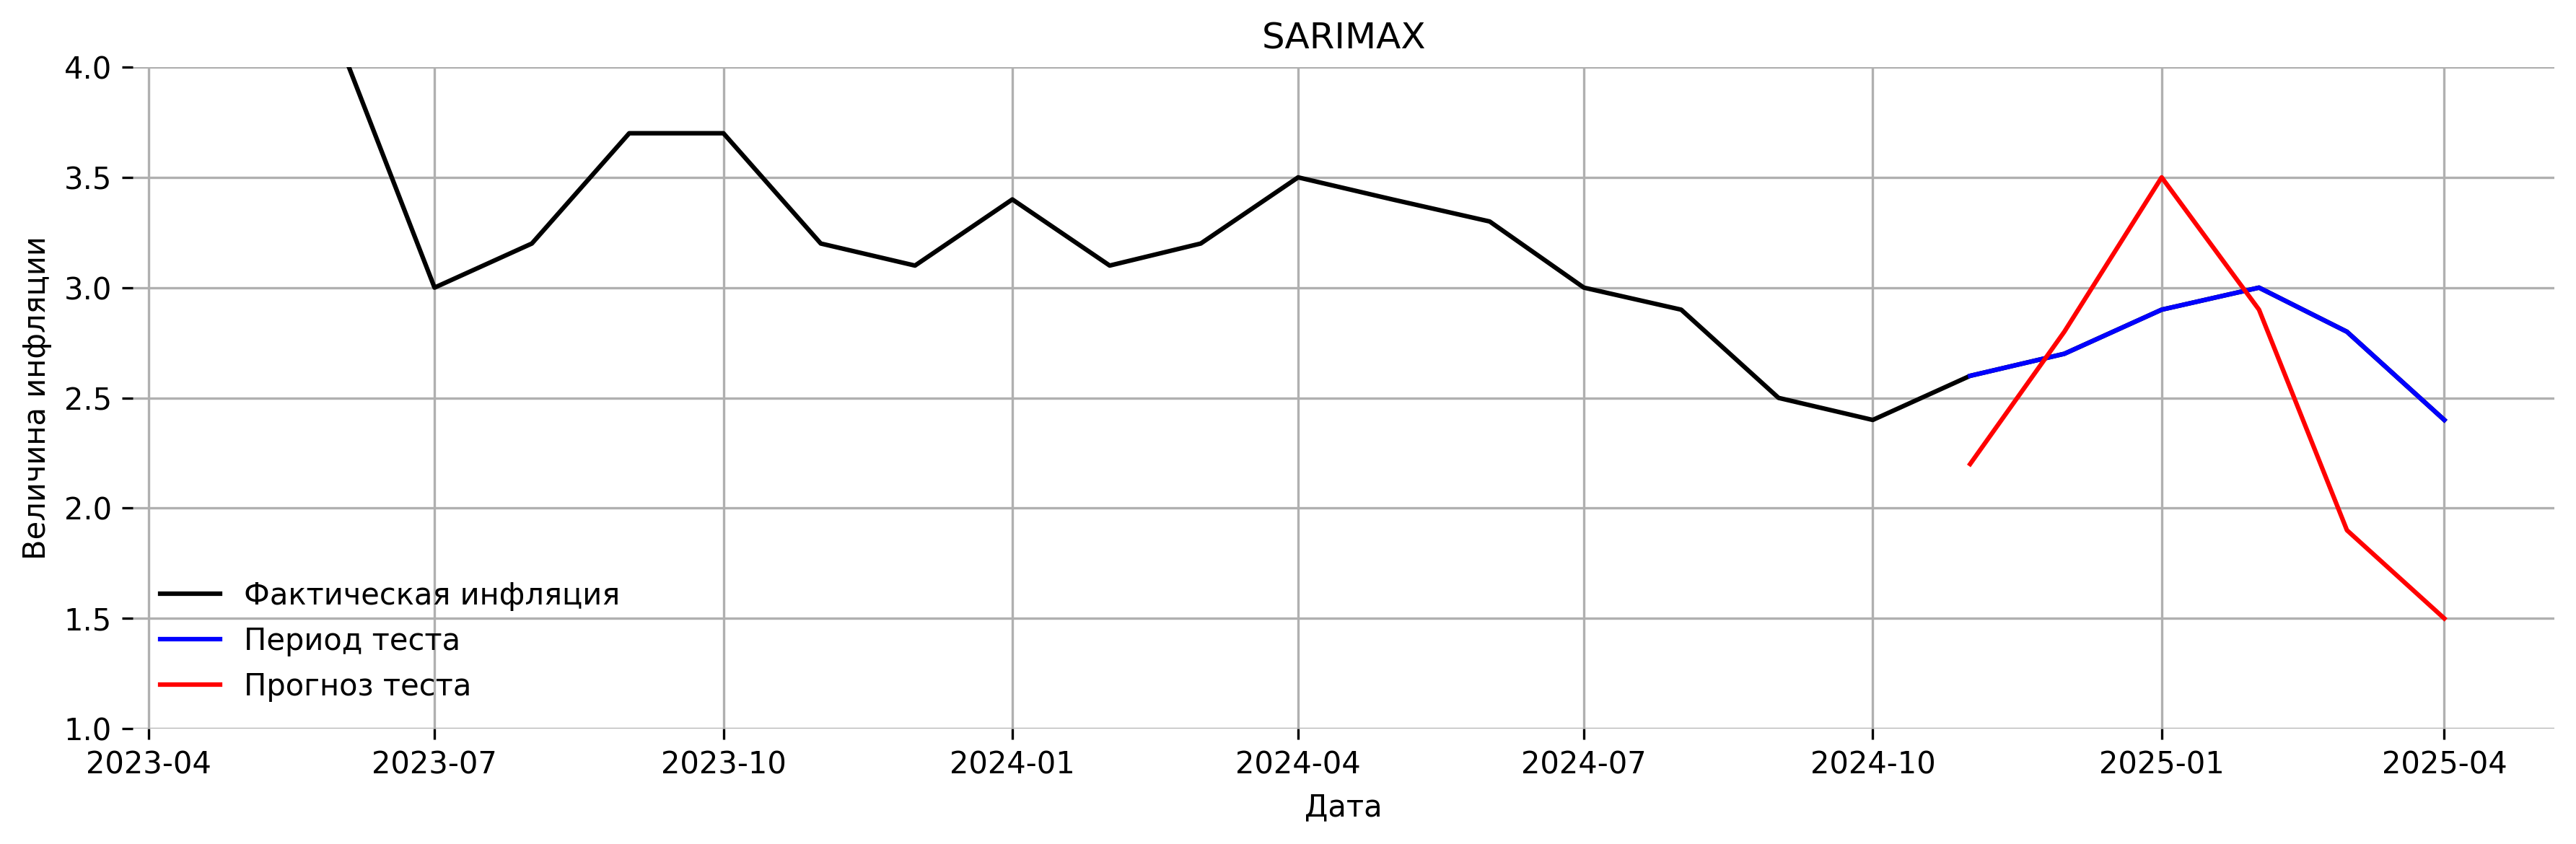

<Figure size 640x480 with 0 Axes>

In [52]:
plt.figure(figsize=(12, 4), dpi=300)

sns.lineplot(data=dataset_for_vizual.iloc[-4*validation_period:],
             x=dataset_for_vizual.iloc[-4*validation_period:].index,
             y='inflation_rate',
             label='Фактическая инфляция',
             color="black")
sns.lineplot(data=dataset_for_vizual.iloc[-validation_period:],
             x=dataset_for_vizual.iloc[-validation_period:].index,
             y='inflation_rate',
             label='Период теста',
             color="blue")
sns.lineplot(data=dataset_for_vizual.iloc[-4*validation_period:],
             x=dataset_for_vizual.iloc[-4*validation_period:].index,
             y='predicted_mean',
             label='Прогноз теста',
             color="red")

plt.xlabel('Дата')
plt.ylabel('Величина инфляции')
plt.ylim(1, 4)
plt.grid(True)
plt.title("SARIMAX")
plt.tight_layout()
leg = plt.legend()
leg.get_frame().set_linewidth(0)
leg.get_frame().set_alpha(0)
plt.rcParams['axes.linewidth'] = 0
plt.show()
plt.savefig("drive/MyDrive/hse_diploma/sarimax.png", dpi=300)